In [107]:
import pandas as pd
import io
import scikit_posthocs as sp
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [10]:
pangenie_svs_sample = read_vcf("../data/pangenie_merged_bi_nosnvs_26sample.vcf")

In [11]:
pangenie_svs_sample.shape

(1129810, 35)

In [12]:
pangenie_svs_sample[['INFO_ID']] = pangenie_svs_sample['INFO'].str.split(';', expand=True)[2]
pangenie_svs_sample['INFO_ID'] = pangenie_svs_sample['INFO_ID'].str.lstrip('ID=')
pangenie_DEL_sample = pangenie_svs_sample[pangenie_svs_sample['INFO_ID'].str.contains('DEL')]
pangenie_INS_sample = pangenie_svs_sample[pangenie_svs_sample['INFO_ID'].str.contains('INS')]

In [13]:
all_DEL_boundary_sig = pd.read_csv('../data/all_DEL_boundary_3_sig_10kbflank.bed', sep='\t', header=0)
all_INS_boundary_sig = pd.read_csv('../data/all_INS_boundary_3_sig_10kbflank.bed', sep='\t', header=0)
all_DEL_boundary_3_sig_SV = all_DEL_boundary_sig['INFO_ID']
all_INS_boundary_3_sig_SV = all_INS_boundary_sig['INFO_ID']

### deletion 

In [15]:
sig_pangenie_DEL_sample = pangenie_DEL_sample[pangenie_DEL_sample['INFO_ID'].isin(all_DEL_boundary_3_sig_SV)]
sig_pangenie_DEL_sample.shape

(66, 36)

In [16]:
sig_pangenie_DEL_sample_new = sig_pangenie_DEL_sample[[
'CHROM', 'FILTER', 'INFO_ID', 'FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011',
    'HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
# removed NA12329

In [17]:
sig_pangenie_DEL_sample_new = sig_pangenie_DEL_sample_new.copy()
for col in sig_pangenie_DEL_sample_new.iloc[:, 4:]:
    sig_pangenie_DEL_sample_new[col] = sig_pangenie_DEL_sample_new[col].str[:3]

In [18]:
for col in sig_pangenie_DEL_sample_new.columns:
    sig_pangenie_DEL_sample_new.loc[sig_pangenie_DEL_sample_new[col].astype(str).str.startswith('0/0'), col] = '0'
    sig_pangenie_DEL_sample_new.loc[sig_pangenie_DEL_sample_new[col].astype(str).str.startswith('0/1'), col] = '1'
    sig_pangenie_DEL_sample_new.loc[sig_pangenie_DEL_sample_new[col].astype(str).str.startswith('1/0'), col] = '1'
    sig_pangenie_DEL_sample_new.loc[sig_pangenie_DEL_sample_new[col].astype(str).str.startswith('1/1'), col] = '2'

In [20]:
# Function to convert to integer if possible
def convert_to_int(val):
    try:
        return int(val)
    except ValueError:
        return val

In [22]:
# Function to count occurrences of missing genotype ".:."
def count_dot_colon(row):
    return (row == '.:.').sum()

In [23]:
# Apply the conversion function to each cell in the relevant columns to keep the original DataFrame unchanged
sig_pangenie_DEL_sample_new.iloc[:, 4:] = sig_pangenie_DEL_sample_new.iloc[:, 4:].applymap(convert_to_int)
# Create a separate DataFrame for numeric operations
numeric_data = sig_pangenie_DEL_sample_new.iloc[:, 4:-1].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
# Calculate the sum of integer values
sig_pangenie_DEL_sample_new['Sum'] = numeric_data.sum(axis=1)
# Filter the DataFrame based on the sum condition
sig_pangenie_DEL_sample_new_atleast5 = sig_pangenie_DEL_sample_new[sig_pangenie_DEL_sample_new['Sum'] >= 5]
# Apply the function to each row starting from the 4th column
sig_pangenie_DEL_sample_new_atleast5['missing_geno'] = sig_pangenie_DEL_sample_new_atleast5.iloc[:, 4:].apply(count_dot_colon, axis=1)
sig_pangenie_DEL_sample_new_atleast5.shape

(66, 32)

In [24]:
# Slice the DataFrame to consider columns from the 5th one onwards
sig_pangenie_DEL_sample_new_atleast5['count_zero'] = (sig_pangenie_DEL_sample_new_atleast5.iloc[:, 4:30] == 0).sum(axis=1)
sig_pangenie_DEL_sample_new_atleast5['count_ones'] = (sig_pangenie_DEL_sample_new_atleast5.iloc[:, 4:30] == 1).sum(axis=1)
sig_pangenie_DEL_sample_new_atleast5['count_twos'] = (sig_pangenie_DEL_sample_new_atleast5.iloc[:, 4:30] == 2).sum(axis=1)
# Count the occurrences of 1 and 2 for each row|

In [25]:
sig_pangenie_DEL_sample_new_filter = sig_pangenie_DEL_sample_new_atleast5[(sig_pangenie_DEL_sample_new_atleast5['count_zero'] >= 5) &
                                                                (sig_pangenie_DEL_sample_new_atleast5['count_ones'] >= 5) &
                                                                (sig_pangenie_DEL_sample_new_atleast5['count_twos'] >= 5)]

In [27]:
sig_pangenie_DEL_sample_new_filter = sig_pangenie_DEL_sample_new_filter.copy()
sig_pangenie_DEL_sample_new_filter['START_POS'] = sig_pangenie_DEL_sample_new_filter['INFO_ID'].str.split('-', expand=True)[1]
sig_pangenie_DEL_sample_new_filter['TYPE'] = sig_pangenie_DEL_sample_new_filter['INFO_ID'].str.split('-', expand=True)[2]
sig_pangenie_DEL_sample_new_filter['LEN'] = sig_pangenie_DEL_sample_new_filter['INFO_ID'].str.split('-', expand=True)[3]
sig_pangenie_DEL_sample_new_filter.iloc[:,[32,34]] = sig_pangenie_DEL_sample_new_filter.iloc[:,[32,34]].astype(str).astype(int)
# VCF files in fact are providing a single 1-based position for a variant, end = start + len -1
sig_pangenie_DEL_sample_new_filter['END_POS'] = sig_pangenie_DEL_sample_new_filter['START_POS'].astype(int) + sig_pangenie_DEL_sample_new_filter['LEN'].astype(int) - 1
sig_pangenie_DEL_sample_new_filter = sig_pangenie_DEL_sample_new_filter[[
'CHROM', 'START_POS','END_POS', 'TYPE','LEN', 'FILTER', 'INFO_ID', 'FORMAT', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732', 'Sum'
    ]]

In [28]:
sig_pangenie_DEL_sample_new_filter.shape

(17, 35)

### insertion 

In [30]:
sig_pangenie_INS_sample = pangenie_INS_sample[pangenie_INS_sample['INFO_ID'].isin(all_INS_boundary_3_sig_SV)]
sig_pangenie_INS_sample.shape

(119, 36)

In [31]:
sig_pangenie_INS_sample_new = sig_pangenie_INS_sample[[
'CHROM', 'FILTER', 'INFO_ID', 'FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
# removed NA12329

In [32]:
sig_pangenie_INS_sample_new = sig_pangenie_INS_sample_new.copy()
for col in sig_pangenie_INS_sample_new.iloc[:, 4:]:
    sig_pangenie_INS_sample_new[col] = sig_pangenie_INS_sample_new[col].str[:3]

In [33]:
for col in sig_pangenie_INS_sample_new.columns:
    sig_pangenie_INS_sample_new.loc[sig_pangenie_INS_sample_new[col].astype(str).str.startswith('0/0'), col] = '0'
    sig_pangenie_INS_sample_new.loc[sig_pangenie_INS_sample_new[col].astype(str).str.startswith('0/1'), col] = '1'
    sig_pangenie_INS_sample_new.loc[sig_pangenie_INS_sample_new[col].astype(str).str.startswith('1/0'), col] = '1'
    sig_pangenie_INS_sample_new.loc[sig_pangenie_INS_sample_new[col].astype(str).str.startswith('1/1'), col] = '2'

In [35]:
# Apply the conversion function to each cell in the relevant columns to keep the original DataFrame unchanged
sig_pangenie_INS_sample_new.iloc[:, 4:] = sig_pangenie_INS_sample_new.iloc[:, 4:].applymap(convert_to_int)
# Create a separate DataFrame for numeric operations
numeric_data = sig_pangenie_INS_sample_new.iloc[:, 4:-1].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
# Calculate the sum of integer values
sig_pangenie_INS_sample_new['Sum'] = numeric_data.sum(axis=1)
# Filter the DataFrame based on the sum condition
sig_pangenie_INS_sample_new_atleast5 = sig_pangenie_INS_sample_new[sig_pangenie_INS_sample_new['Sum'] >= 5]
# Apply the function to each row starting from the 4th column
sig_pangenie_INS_sample_new_atleast5['missing_geno'] = sig_pangenie_INS_sample_new_atleast5.iloc[:, 4:].apply(count_dot_colon, axis=1)
sig_pangenie_INS_sample_new_atleast5.shape

(119, 32)

In [36]:
# Slice the DataFrame to consider columns from the 5th one onwards
sig_pangenie_INS_sample_new_atleast5['count_zero'] = (sig_pangenie_INS_sample_new_atleast5.iloc[:, 4:30] == 0).sum(axis=1)
sig_pangenie_INS_sample_new_atleast5['count_ones'] = (sig_pangenie_INS_sample_new_atleast5.iloc[:, 4:30] == 1).sum(axis=1)
sig_pangenie_INS_sample_new_atleast5['count_twos'] = (sig_pangenie_INS_sample_new_atleast5.iloc[:, 4:30] == 2).sum(axis=1)
# Count the occurrences of 1 and 2 for each row

In [37]:
sig_pangenie_INS_sample_new_filter = sig_pangenie_INS_sample_new_atleast5[(sig_pangenie_INS_sample_new_atleast5['count_zero'] >= 5) &
                                                                (sig_pangenie_INS_sample_new_atleast5['count_ones'] >= 5) &
                                                                (sig_pangenie_INS_sample_new_atleast5['count_twos'] >= 5)]

In [39]:
sig_pangenie_INS_sample_new_filter = sig_pangenie_INS_sample_new_filter.copy()
sig_pangenie_INS_sample_new_filter['START_POS'] = sig_pangenie_INS_sample_new_filter['INFO_ID'].str.split('-', expand=True)[1]
sig_pangenie_INS_sample_new_filter['TYPE'] = sig_pangenie_INS_sample_new_filter['INFO_ID'].str.split('-', expand=True)[2]
sig_pangenie_INS_sample_new_filter['LEN'] = sig_pangenie_INS_sample_new_filter['INFO_ID'].str.split('-', expand=True)[3]
sig_pangenie_INS_sample_new_filter.iloc[:,[32,34]] = sig_pangenie_INS_sample_new_filter.iloc[:,[32,34]].astype(str).astype(int)
sig_pangenie_INS_sample_new_filter['END_POS'] = sig_pangenie_INS_sample_new_filter['START_POS']
sig_pangenie_INS_sample_new_filter = sig_pangenie_INS_sample_new_filter[[
'CHROM', 'START_POS','END_POS', 'TYPE','LEN', 'FILTER', 'INFO_ID', 'FORMAT', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732', 'Sum'
    ]]

In [40]:
sig_pangenie_INS_sample_new_filter.shape

(28, 35)

### homo/heter SVs' impact on boundary strength 

In [41]:
DEL_boundary_genotype = sig_pangenie_DEL_sample_new_filter[[
'CHROM', 'START_POS', 'END_POS', 'TYPE', 'LEN', 'FILTER', 'INFO_ID','FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
INS_boundary_genotype = sig_pangenie_INS_sample_new_filter[[
'CHROM', 'START_POS', 'END_POS', 'TYPE', 'LEN', 'FILTER', 'INFO_ID','FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]

In [42]:
DEL_boundary_genotype_1 = DEL_boundary_genotype.reset_index(drop=True)
DEL_boundary_genotype_1.shape

(17, 34)

In [43]:
INS_boundary_genotype_1 = INS_boundary_genotype.reset_index(drop=True)
INS_boundary_genotype_1.shape

(28, 34)

In [44]:
all_DEL_boundary_id = list(sig_pangenie_DEL_sample_new_filter['INFO_ID'])
DEL_list = list(set(all_DEL_boundary_id))
len(DEL_list)

17

In [45]:
all_INS_boundary_id = list(sig_pangenie_INS_sample_new_filter['INFO_ID'])
INS_list = list(set(all_INS_boundary_id))
len(INS_list)

28

In [48]:
sig_DEL_boundary = all_DEL_boundary_sig[all_DEL_boundary_sig['INFO_ID'].isin(all_DEL_boundary_id)].reset_index(drop=True)
sig_DEL_boundary.shape

(17, 37)

In [49]:
sig_INS_boundary = all_INS_boundary_sig[all_INS_boundary_sig['INFO_ID'].isin(all_INS_boundary_id)].reset_index(drop=True)
sig_INS_boundary.shape

(28, 37)

In [52]:
pvalue = []
entries_without_1 = []
entries_without_2 = []

for i in range(len(sig_DEL_boundary)):
    DEL_boundary_genotype_all = DEL_boundary_genotype_1[DEL_boundary_genotype_1['INFO_ID'] == sig_DEL_boundary.loc[i, 'INFO_ID']].iloc[:, 8:]
    genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = sig_DEL_boundary.iloc[i, 8:34].values.tolist()

    df = pd.DataFrame({'genotypes': genotypes_list, 'boundary_score': boundary_score_list})
    
    # Convert the 'genotypes' column to string type
    df['genotypes'] = df['genotypes'].astype(str)

    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS', 'genotypes', 'boundary_score')

    if '1' not in df_new.columns:
        entries_without_1.append(df_new)
        p = 'NA'
    elif '2' not in df_new.columns:
        entries_without_2.append(df_new)
        p = 'NA'
    else:
        try:
            if all(genotype in df_new.columns for genotype in ['0', '1', '2']):
                H, p = stats.kruskal(df_new['0'].dropna().tolist(),
                                     df_new['1'].dropna().tolist(),
                                     df_new['2'].dropna().tolist())
            else:
                p = 'NA'
        except ValueError:
            p = 'NA'

    pvalue.append(p)

sig_DEL_boundary['pvalue_0_1_2'] = pvalue

# Display or process the entries without column [1]
print("The num of SVs that do not have the homozygote:", len(entries_without_1))
for entry in entries_without_1:
    print(entry)

# Display or process the entries without column [2]
print("The num of SVs that do not have the heterozygote:", len(entries_without_2))
for entry in entries_without_2:
    print(entry)

The num of SVs that do not have the homozygote: 0
The num of SVs that do not have the heterozygote: 0


In [54]:
def fdr_correction_heter(group):
    _, corrected_pvalues, _, _ = multipletests(group['pvalue_0_1_2'], method='fdr_bh')
    group['qvalue_0_1_2'] = corrected_pvalues
    return group

In [58]:
sig_DEL_boundary_fdr = sig_DEL_boundary.groupby('INFO_ID').apply(fdr_correction_heter)
sig_DEL_boundary_fdr.to_csv('../data/final_homo_heter_TAD-DEL_qvalue.bed', index = False, sep='\t', header=True)

In [61]:
pvalue = []
entries_without_1 = []
entries_without_2 = []

for i in range(len(sig_INS_boundary)):
    INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1['INFO_ID'] == sig_INS_boundary.loc[i, 'INFO_ID']].iloc[:, 8:]
    genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = sig_INS_boundary.iloc[i, 8:34].values.tolist()

    df = pd.DataFrame({'genotypes': genotypes_list, 'boundary_score': boundary_score_list})
    
    # Convert the 'genotypes' column to string type
    df['genotypes'] = df['genotypes'].astype(str)

    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS', 'genotypes', 'boundary_score')

    if '1' not in df_new.columns:
        entries_without_1.append(df_new)
        p = 'NA'
    elif '2' not in df_new.columns:
        entries_without_2.append(df_new)
        p = 'NA'
    else:
        try:
            if all(genotype in df_new.columns for genotype in ['0', '1', '2']):
                H, p = stats.kruskal(df_new['0'].dropna().tolist(),
                                     df_new['1'].dropna().tolist(),
                                     df_new['2'].dropna().tolist())
            else:
                p = 'NA'
                
        except ValueError:
            p = 'NA'

    pvalue.append(p)

sig_INS_boundary['pvalue_0_1_2'] = pvalue

# Display or process the entries without column [1]
print("The num of SVs that do not have the homozygote:", len(entries_without_1))
for entry in entries_without_1:
    print(entry)

# Display or process the entries without column [2]
print("The num of SVs that do not have the heterozygote:", len(entries_without_2))
for entry in entries_without_2:
    print(entry)

The num of SVs that do not have the homozygote: 0
The num of SVs that do not have the heterozygote: 0


In [62]:
sig_INS_boundary_fdr = sig_INS_boundary.groupby('INFO_ID').apply(fdr_correction_heter)
sig_INS_boundary_fdr.to_csv('../data/final_homo_heter_TAD-INS_qvalue.bed', index = False, sep='\t', header=True)

In [64]:
all_DEL_boundary_3_sig_noNA = sig_DEL_boundary_fdr[sig_DEL_boundary_fdr['qvalue_0_1_2'] != 'NA']
all_DEL_boundary_3_sig_KW = all_DEL_boundary_3_sig_noNA[all_DEL_boundary_3_sig_noNA['qvalue_0_1_2'].astype(float) < 0.05]
all_DEL_boundary_3_sig_KW_new = all_DEL_boundary_3_sig_KW.reset_index(drop=True)
all_DEL_boundary_3_sig_KW_new.shape

(11, 39)

In [65]:
len(all_DEL_boundary_3_sig_KW_new['INFO_ID'].drop_duplicates())

11

In [66]:
all_INS_boundary_3_sig_noNA = sig_INS_boundary_fdr[sig_INS_boundary_fdr['qvalue_0_1_2'] != 'NA']
all_INS_boundary_3_sig_KW = all_INS_boundary_3_sig_noNA[all_INS_boundary_3_sig_noNA['qvalue_0_1_2'].astype(float) < 0.05]
all_INS_boundary_3_sig_KW_new = all_INS_boundary_3_sig_KW.reset_index(drop=True)
all_INS_boundary_3_sig_KW_new.shape

(21, 39)

In [67]:
len(all_INS_boundary_3_sig_KW_new['INFO_ID'].drop_duplicates())

21

### Post hoc analysis 

In [69]:
pvalue_01 = []
pvalue_02 = []
pvalue_12 = []

for i in range(len(all_DEL_boundary_3_sig_KW_new)):
    DEL_boundary_genotype_all = DEL_boundary_genotype_1[DEL_boundary_genotype_1['INFO_ID'] == all_DEL_boundary_3_sig_KW_new.loc[i, 'INFO_ID']].iloc[:, 8:]
    genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = all_DEL_boundary_3_sig_KW_new.iloc[i, 8:34].values.tolist()

    df = pd.DataFrame({'genotypes': genotypes_list, 'boundary_score': boundary_score_list})
    
    # Convert the 'genotypes' column to string type
    df['genotypes'] = df['genotypes'].astype(str)

    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS', 'genotypes', 'boundary_score')


    try:
        p_values = sp.posthoc_conover([df_new['0'].dropna().tolist(), 
                                       df_new['1'].dropna().tolist(), 
                                       df_new['2'].dropna().tolist()], p_adjust='holm')
        
        # Extract the relevant p-values
        p_01 = p_values.loc[1, 2] if (1 in p_values.columns and 2 in p_values.columns) else 'NA'
        p_02 = p_values.loc[1, 3] if (1 in p_values.columns and 3 in p_values.columns) else 'NA'
        p_12 = p_values.loc[2, 3] if (2 in p_values.columns and 3 in p_values.columns) else 'NA'

    except ValueError:
        p_01 = p_02 = p_12 = 'NA'

    pvalue_01.append(p_01)
    pvalue_02.append(p_02)
    pvalue_12.append(p_12)

all_DEL_boundary_3_sig_KW_new['pvalue_01'] = pvalue_01
all_DEL_boundary_3_sig_KW_new['pvalue_02'] = pvalue_02
all_DEL_boundary_3_sig_KW_new['pvalue_12'] = pvalue_12

In [71]:
all_DEL_boundary_3_sig_KW_new_sig_1 = all_DEL_boundary_3_sig_KW_new[all_DEL_boundary_3_sig_KW_new['pvalue_12'] < 0.05]
all_DEL_boundary_3_sig_KW_new_sig_1

,CHROM,START_POS,END_POS,INFO_ID,BOUND_CHR,FLANK_START,FLANK_END,BOUND_SCORE,GM18534,GM18939,...,HG03683,HG03732,num_NaNs,pvalue_0_1,qvalue,pvalue_0_1_2,qvalue_0_1_2,pvalue_01,pvalue_02,pvalue_12
9,chr7,149878840,149879003,chr7-149878840-DEL-164,chr7,149875001,149900000,0.620092,1.551176,0.719347,...,0.804217,1.405294,8,0.023057,0.023057,0.007835,0.007835,0.211861,0.002817,0.036733


In [94]:
pvalue_01 = []
pvalue_02 = []
pvalue_12 = []

for i in range(len(all_INS_boundary_3_sig_KW_new)):
    INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1['INFO_ID'] == all_INS_boundary_3_sig_KW_new.loc[i, 'INFO_ID']].iloc[:, 8:]
    genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = all_INS_boundary_3_sig_KW_new.iloc[i, 8:34].values.tolist()

    df = pd.DataFrame({'genotypes': genotypes_list, 'boundary_score': boundary_score_list})
    
    # Convert the 'genotypes' column to string type
    df['genotypes'] = df['genotypes'].astype(str)
    
    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS', 'genotypes', 'boundary_score')

    try:
        p_values = sp.posthoc_conover([df_new['0'].dropna().tolist(), 
                                       df_new['1'].dropna().tolist(), 
                                       df_new['2'].dropna().tolist()], p_adjust='holm')
        
        # Extract the relevant p-values
        p_01 = p_values.loc[1, 2] if (1 in p_values.columns and 2 in p_values.columns) else 'NA'
        p_02 = p_values.loc[1, 3] if (1 in p_values.columns and 3 in p_values.columns) else 'NA'
        p_12 = p_values.loc[2, 3] if (2 in p_values.columns and 3 in p_values.columns) else 'NA'

    except ValueError:
        p_01 = p_02 = p_12 = 'NA'

    pvalue_01.append(p_01)
    pvalue_02.append(p_02)
    pvalue_12.append(p_12)

all_INS_boundary_3_sig_KW_new['pvalue_01'] = pvalue_01
all_INS_boundary_3_sig_KW_new['pvalue_02'] = pvalue_02
all_INS_boundary_3_sig_KW_new['pvalue_12'] = pvalue_12

In [95]:
all_INS_boundary_3_sig_KW_new_sig_1 = all_INS_boundary_3_sig_KW_new[all_INS_boundary_3_sig_KW_new['pvalue_12'] < 0.05]
all_INS_boundary_3_sig_KW_new_sig_1

,CHROM,START_POS,END_POS,INFO_ID,BOUND_CHR,FLANK_START,FLANK_END,BOUND_SCORE,GM18534,GM18939,...,HG03683,HG03732,num_NaNs,pvalue_0_1,qvalue,pvalue_0_1_2,qvalue_0_1_2,pvalue_01,pvalue_02,pvalue_12
11,chr3,84900406,84900406,chr3-84900406-INS-15193,chr3,84890001,84915000,0.245090,0.685173,0.0,...,0.219085,0.413103,8,0.005990,0.005990,0.000709,0.000709,0.099375,0.000103,0.001087
16,chr6,170399369,170399369,chr6-170399369-INS-349,chr6,170390001,170415000,0.247605,0.000000,0.0,...,0.403806,0.000000,12,0.015513,0.015513,0.000429,0.000429,0.237798,0.000018,0.000214


### visualization 

In [142]:
boundary_score_list = all_DEL_boundary_3_sig_KW_new.loc[9][8:34].values.tolist()
DEL_boundary_genotype_all = DEL_boundary_genotype_1[DEL_boundary_genotype_1.loc[:,'INFO_ID'] == all_DEL_boundary_3_sig_KW_new.loc[9]['INFO_ID']].iloc[:,8:]
genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})    
df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')

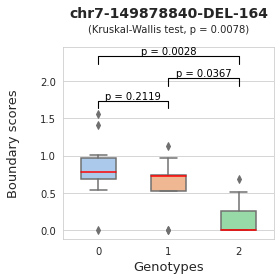

<Figure size 432x288 with 0 Axes>

In [148]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_new[[0, 1, 2]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Boundary scores', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('chr7-149878840-DEL-164', pad=30, fontsize=14, fontweight='bold')
# Add the secondary title as a separate text element
ax.text(0.5, 1.07, '(Kruskal-Wallis test, p = 0.0078)', ha='center', va='bottom', transform=ax.transAxes, fontsize=10)

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2, x3 = 0, 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_new[1].max() + 0.2, 0.1, 'k'


# group 1 vs 2
plt.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+4*h, "p = 0.2119", ha='center', va='bottom', color=col)

# group 1 vs 3
plt.plot([x1, x1, x3, x3], [y+9*h, y+10*h, y+10*h, y+9*h], lw=1.1, c=col)
plt.text((x1+x3)*.5, y+10*h, "p = 0.0028", ha='center', va='bottom', color=col)

# group 2 vs 3
plt.plot([x2, x2, x3, x3], [y+6*h,  y+7*h,  y+7*h, y+6*h], lw=1.1, c=col)
plt.text((x2+x3)*.5, y+7*h, "p = 0.0367", ha='center', va='bottom', color=col)

plt.show()
# Adjust the layout to add extra space at the top
plt.subplots_adjust(top=1.85)

In [149]:
boundary_score_list = all_INS_boundary_3_sig_KW_new.loc[11][8:34].values.tolist()
INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1.loc[:,'INFO_ID'] == all_INS_boundary_3_sig_KW_new.loc[11]['INFO_ID']].iloc[:,8:]
genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})    
df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')

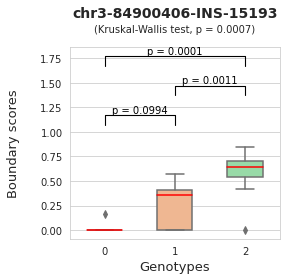

<Figure size 432x288 with 0 Axes>

In [150]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_new[[0, 1, 2]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Boundary scores', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('chr3-84900406-INS-15193', pad=30, fontsize=14, fontweight='bold')
# Add the secondary title as a separate text element
ax.text(0.5, 1.07, '(Kruskal-Wallis test, p = 0.0007)', ha='center', va='bottom', transform=ax.transAxes, fontsize=10)

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2, x3 = 0, 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_new[1].max() + 0.2, 0.1, 'k'

# group 1 vs 2
plt.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+4*h, "p = 0.0994", ha='center', va='bottom', color=col)

# group 1 vs 3
plt.plot([x1, x1, x3, x3], [y+9*h, y+10*h, y+10*h, y+9*h], lw=1.1, c=col)
plt.text((x1+x3)*.5, y+10*h, "p = 0.0001", ha='center', va='bottom', color=col)

# group 2 vs 3
plt.plot([x2, x2, x3, x3], [y+6*h,  y+7*h,  y+7*h, y+6*h], lw=1.1, c=col)
plt.text((x2+x3)*.5, y+7*h, "p = 0.0011", ha='center', va='bottom', color=col)

plt.show()
# Adjust the layout to add extra space at the top
plt.subplots_adjust(top=1.85)

In [151]:
boundary_score_list = all_INS_boundary_3_sig_KW_new.loc[16][8:34].values.tolist()
INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1.loc[:,'INFO_ID'] == all_INS_boundary_3_sig_KW_new.loc[16]['INFO_ID']].iloc[:,8:]
genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})    
df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')

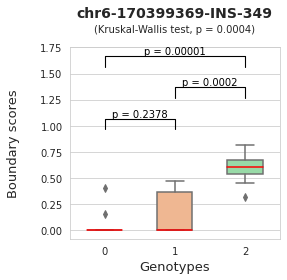

<Figure size 432x288 with 0 Axes>

In [152]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_new[[0, 1, 2]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Boundary scores', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('chr6-170399369-INS-349', pad=30, fontsize=14, fontweight='bold')
# Add the secondary title as a separate text element
ax.text(0.5, 1.07, '(Kruskal-Wallis test, p = 0.0004)', ha='center', va='bottom', transform=ax.transAxes, fontsize=10)

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2, x3 = 0, 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_new[1].max() + 0.2, 0.1, 'k'

# group 1 vs 2
plt.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+4*h, "p = 0.2378", ha='center', va='bottom', color=col)

# group 1 vs 3
plt.plot([x1, x1, x3, x3], [y+9*h, y+10*h, y+10*h, y+9*h], lw=1.1, c=col)
plt.text((x1+x3)*.5, y+10*h, "p = 0.00001", ha='center', va='bottom', color=col)

# group 2 vs 3
plt.plot([x2, x2, x3, x3], [y+6*h,  y+7*h,  y+7*h, y+6*h], lw=1.1, c=col)
plt.text((x2+x3)*.5, y+7*h, "p = 0.0002", ha='center', va='bottom', color=col)

plt.show()
# Adjust the layout to add extra space at the top
plt.subplots_adjust(top=1.85)